In [75]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import causalpy as cp
import arviz as az
# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
def read_data(file): 
    return pd.read_stata("https://raw.github.com/scunning1975/mixtape/master/" + file)



texas = read_data("texas.dta")

In [68]:
d = texas.groupby(['state', 'year']).mean()['bmprison'].unstack().T

In [69]:
d.columns = d.columns.str.replace(' ', '')

In [70]:
eqn_str = 'Texas ~'
for s in list(zip(d.columns[d.columns != 'Texas'], ['+']*50)):
    eqn_str += ' ' + s[0]
    if s[0] == 'Wyoming':
        continue
    eqn_str += ' ' + s[1]    

In [71]:
eqn_str

'Texas ~ Alabama + Alaska + Arizona + Arkansas + California + Colorado + Connecticut + Delaware + DistrictofColumbia + Florida + Georgia + Hawaii + Idaho + Illinois + Indiana + Iowa + Kansas + Kentucky + Louisiana + Maine + Maryland + Massachusetts + Michigan + Minnesota + Mississippi + Missouri + Montana + Nebraska + Nevada + NewHampshire + NewJersey + NewMexico + NewYork + NorthCarolina + NorthDakota + Ohio + Oklahoma + Oregon + Pennsylvania + RhodeIsland + SouthCarolina + SouthDakota + Tennessee + Utah + Vermont + Virginia + Washington + WestVirginia + Wisconsin + Wyoming'

In [72]:
treatment_time = 1993
result = cp.pymc_experiments.SyntheticControl(
    d,
    treatment_time,
    formula=eqn_str,
    prediction_model=cp.pymc_models.WeightedSumFitter(),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/ll17354/opt/anaconda3/envs/causal_inference_mixtape/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ll17354/opt/anaconda3/envs/causal_inference_mixtape/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ll17354/opt/anaconda3/envs/causal_inference_mixtape/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
 

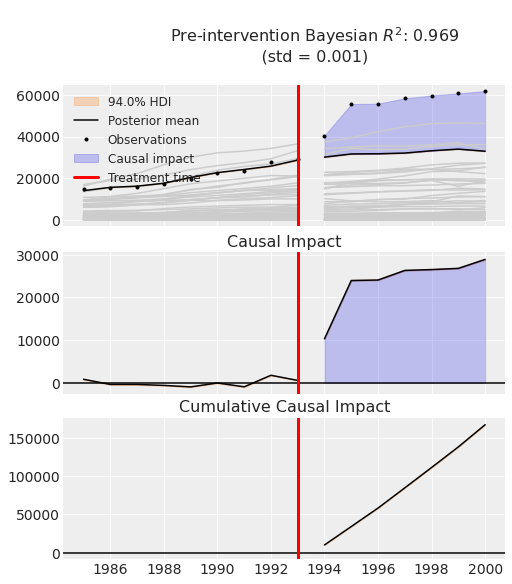

In [73]:
fig, ax = result.plot(plot_predictors=True)

In [76]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,166982.3,346.867,166351.494,167658.216,5.366,3.795,4179.0,2785.0,1.0


So we can see that the over cumulative causal impact of the 1993 building of more prisons in Texas led to an estimated 166982 +/- 347 additional black male prisoners